# Data Exploration

## Import libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnull
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Matplotlib created a temporary cache directory at /scratch/zzhao8/job_30426487/matplotlib-54jroqd4 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# initialize a Spark session
driver_memory = "16g"
executor_memory = "16g"
n_executors = 8 - 1
spark = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config("spark.executor.instances", n_executors) \
                             .getOrCreate()

## 30min parquet file

In [3]:
min30_file = '/expanse/lustre/projects/uci150/jtayag/Group_Project/30min.parquet'

# load Parquet file
min30_df = spark.read.parquet(min30_file)

min30_df.show(5)
min30_df.printSchema()

+-------------+-------------------+-----+
|generation_wh|           datetime|ss_id|
+-------------+-------------------+-----+
|          0.0|2010-11-18 00:00:00| 2405|
|          0.0|2010-11-18 00:30:00| 2405|
|          0.0|2010-11-18 01:00:00| 2405|
|          0.0|2010-11-18 01:30:00| 2405|
|          0.0|2010-11-18 02:00:00| 2405|
+-------------+-------------------+-----+
only showing top 5 rows

root
 |-- generation_wh: double (nullable = true)
 |-- datetime: timestamp_ntz (nullable = true)
 |-- ss_id: long (nullable = true)



In [4]:
# check for nulls in each column
min30_null_counts = min30_df.select([count(when(col(c).isNull(), c)).alias(c) for c in min30_df.columns])
print("Null counts:")
min30_null_counts.show()

Null counts:
+-------------+--------+-----+
|generation_wh|datetime|ss_id|
+-------------+--------+-----+
|      1824349|       0|    0|
+-------------+--------+-----+



In [5]:
def convert_counts_to_percentages(df, total_rows):
    for name in df.columns:
        df = df.withColumn(name, (col(name) / total_rows) * 100)
    return df

# calculate total rows for percentage calculation
min30_df_rows = min30_df.count()

# convert counts to percentages
min30_null_percentages = convert_counts_to_percentages(min30_null_counts, min30_df_rows)
min30_null_percentages.show(truncate=False, vertical=True)

-RECORD 0----------------------------
 generation_wh | 0.06899923489645765 
 datetime      | 0.0                 
 ss_id         | 0.0                 



In [6]:
def count_complete_and_incomplete(df):
    checks = []
    
    for name, dtype in df.dtypes:
        non_null = count(when(col(name).isNotNull(), 1)).alias(f"{name}_nonull")
        null = count(when(col(name).isNull(), 1)).alias(f"{name}_null")
        
        checks.append(non_null)
        checks.append(null)
    
    return df.agg(*checks)

# apply function
min30_counts = count_complete_and_incomplete(min30_df)
min30_counts.show(truncate=False, vertical=True)

min30_counts_pd = min30_counts.toPandas()
min30_counts_pd_transposed = min30_counts_pd.T
min30_counts_pd_transposed.reset_index(inplace=True)
min30_counts_pd_transposed.columns = ['column_type', 'count']

# split 'column_type' into two parts: 'column' and 'type'
min30_counts_pd_transposed[['column', 'type']] = min30_counts_pd_transposed['column_type'].str.rsplit('_', n=1, expand=True)

item_original_order = ['generation_wh', 'datetime', 'ss_id']

# create pivot table
result = min30_counts_pd_transposed.pivot_table(index='column', columns='type', values='count', aggfunc='sum')
result = result.reindex(item_original_order)
result

-RECORD 0--------------------------
 generation_wh_nonull | 2642189027 
 generation_wh_null   | 1824349    
 datetime_nonull      | 2644013376 
 datetime_null        | 0          
 ss_id_nonull         | 2644013376 
 ss_id_null           | 0          



type,nonull,null
column,,
generation_wh,2642189027,1824349
datetime,2644013376,0
ss_id,2644013376,0


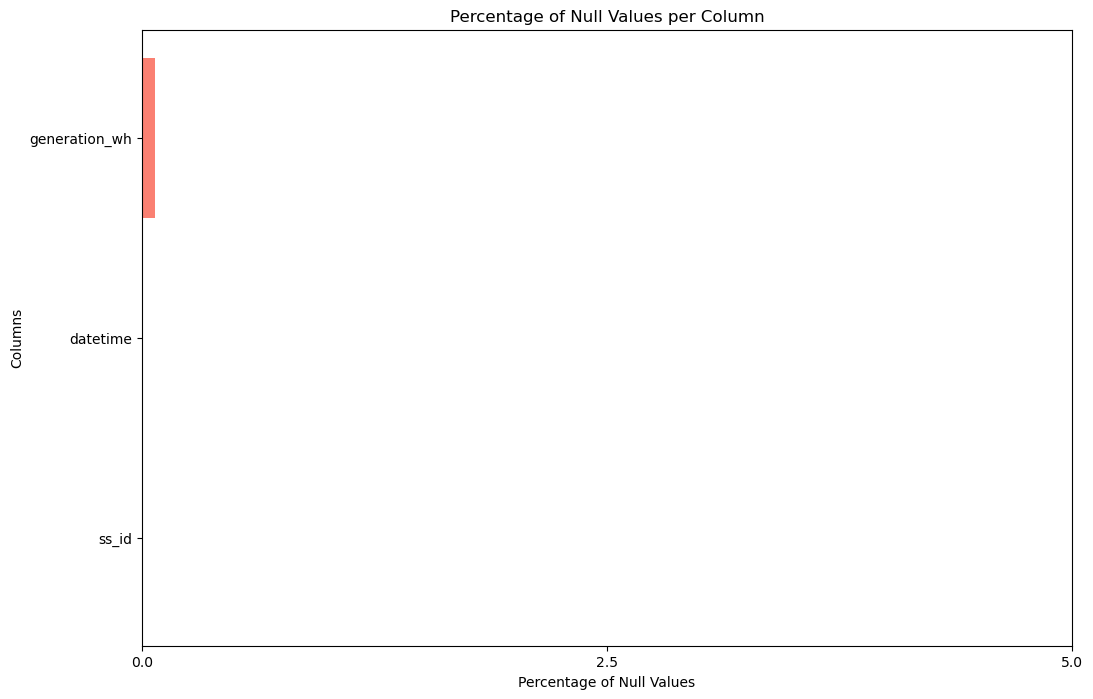

In [7]:
min30_null_empty_pd = min30_null_percentages.toPandas()
min30_null_empty_pd = min30_null_empty_pd.transpose()
min30_null_empty_pd.columns = ['percentage']
min30_null_empty_pd = min30_null_empty_pd.reset_index()
min30_null_empty_pd.columns = ['column', 'percentage']

plt.figure(figsize=(12, 8))
plt.barh(min30_null_empty_pd['column'], min30_null_empty_pd['percentage'], color='salmon')
plt.xlabel('Percentage of Null Values')
plt.ylabel('Columns')
plt.title('Percentage of Null Values per Column')
plt.gca().invert_yaxis()  # invert y axis to have the columns listed top-down

plt.xlim(0, 5)
plt.xticks([0, 2.5, 5])
plt.savefig("min30_null_percents.png")

### Preprocessing
- Add date and time columns for visualizations:
    - **stamp_date:** Date as extracted from the timestamp column
    - **stamp_time_m:** Number of minutes from midnight on any given day
    - **stamp_time:** The string representing the time as extracted from the timestamp column
    - **power_kW:** Converting generation_wh which is in Watts*(30 min) to kW

In [8]:
conversion = (60/30) * (1/1000)
min30_df2 = min30_df.select("generation_wh", "ss_id", F.col("datetime").alias("timestamp")) \
        .withColumn("stamp_date", F.to_date("timestamp")) \
        .withColumn("stamp_time_m", F.hour("timestamp") * F.lit(60) + F.minute("timestamp")) \
        .withColumn("stamp_time", F.split("timestamp", " ")[1]) \
        .withColumn("power_kW", F.col("generation_wh") * F.lit(conversion))

min30_df2.show(5)
min30_df2.printSchema()

+-------------+-----+-------------------+----------+------------+----------+--------+
|generation_wh|ss_id|          timestamp|stamp_date|stamp_time_m|stamp_time|power_kW|
+-------------+-----+-------------------+----------+------------+----------+--------+
|          0.0| 2405|2010-11-18 00:00:00|2010-11-18|           0|  00:00:00|     0.0|
|          0.0| 2405|2010-11-18 00:30:00|2010-11-18|          30|  00:30:00|     0.0|
|          0.0| 2405|2010-11-18 01:00:00|2010-11-18|          60|  01:00:00|     0.0|
|          0.0| 2405|2010-11-18 01:30:00|2010-11-18|          90|  01:30:00|     0.0|
|          0.0| 2405|2010-11-18 02:00:00|2010-11-18|         120|  02:00:00|     0.0|
+-------------+-----+-------------------+----------+------------+----------+--------+
only showing top 5 rows

root
 |-- generation_wh: double (nullable = true)
 |-- ss_id: long (nullable = true)
 |-- timestamp: timestamp_ntz (nullable = true)
 |-- stamp_date: date (nullable = true)
 |-- stamp_time_m: integer (

In [9]:
min30_df2.createOrReplaceTempView("min30_df2")

ss_ids = [2607, 2660, 14531]
timestamp_start = "2019-05-06 00:00:00"
timestamp_end = "2019-05-06 23:59:59"
ss_id_list = ", ".join(map(str, ss_ids))  # convert list of IDs to a string for query
show_n_results = 10

# query
query_desc = "View data from selected system IDs on 2019-05-06"
query = f"""
SELECT *
FROM min30_df2
WHERE timestamp BETWEEN '{timestamp_start}' AND '{timestamp_end}'
AND ss_id IN ({ss_id_list})
ORDER BY ss_id, timestamp;
"""

print(query_desc)
print(query)
result = spark.sql(query)
result.show(show_n_results)


View data from selected system IDs on 2019-05-06

SELECT *
FROM min30_df2
WHERE timestamp BETWEEN '2019-05-06 00:00:00' AND '2019-05-06 23:59:59'
AND ss_id IN (2607, 2660, 14531)
ORDER BY ss_id, timestamp;

+-------------+-----+-------------------+----------+------------+----------+--------+
|generation_wh|ss_id|          timestamp|stamp_date|stamp_time_m|stamp_time|power_kW|
+-------------+-----+-------------------+----------+------------+----------+--------+
|          0.0| 2607|2019-05-06 00:00:00|2019-05-06|           0|  00:00:00|     0.0|
|          0.0| 2607|2019-05-06 00:30:00|2019-05-06|          30|  00:30:00|     0.0|
|          0.0| 2607|2019-05-06 01:00:00|2019-05-06|          60|  01:00:00|     0.0|
|          0.0| 2607|2019-05-06 01:30:00|2019-05-06|          90|  01:30:00|     0.0|
|          0.0| 2607|2019-05-06 02:00:00|2019-05-06|         120|  02:00:00|     0.0|
|          0.0| 2607|2019-05-06 02:30:00|2019-05-06|         150|  02:30:00|     0.0|
|          0.0| 260

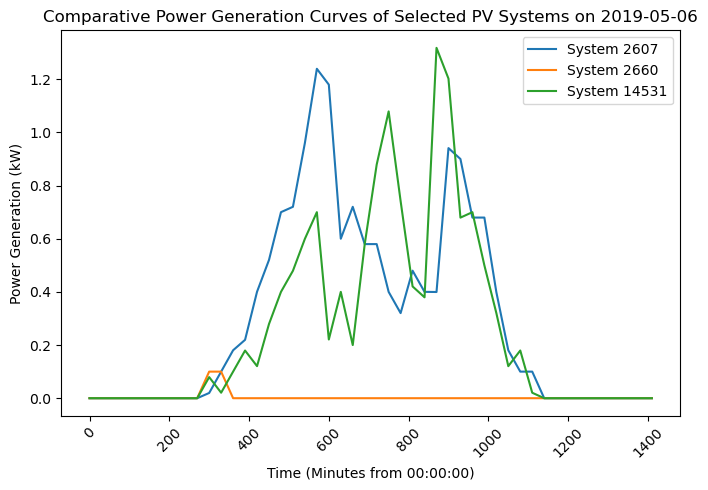

In [10]:
# convert Spark DataFrame to Pandas DataFrame for plotting
result_pd = result.toPandas()

plt.figure(figsize=(7, 5))
for ss_id in ss_ids:
    subset = result_pd[result_pd['ss_id'] == ss_id]
    plt.plot(subset['stamp_time_m'], subset['power_kW'], label=f'System {ss_id}')

plt.title('Comparative Power Generation Curves of Selected PV Systems on 2019-05-06')
plt.xlabel('Time (Minutes from 00:00:00)')
plt.ylabel('Power Generation (kW)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("compare_power_gen.png")

## PV systems metadata

In [11]:
meta_file = '/expanse/lustre/projects/uci150/jtayag/Group_Project/metadata.csv'

meta_df = spark.read.csv(meta_file, inferSchema=True, header=True)
meta_df_count = meta_df.count()
print(f"Meta dataset has {meta_df_count} rows")
meta_df.show(5)
meta_df.printSchema()

Meta dataset has 24662 rows
+-----+----------------+-----------------+---------+-----------+----+----+--------------+
|ss_id|latitude_rounded|longitude_rounded|  llsoacd|orientation|tilt| kwp|operational_at|
+-----+----------------+-----------------+---------+-----------+----+----+--------------+
| 2405|           53.53|            -1.63|E01007430|      180.0|35.0|3.36|    2010-11-18|
| 2406|           54.88|            -1.38|E01008780|      315.0|30.0|1.89|    2010-12-03|
| 2407|           54.88|            -1.38|E01008780|      225.0|30.0|1.89|    2010-12-03|
| 2408|           54.88|            -1.38|E01008780|      225.0|30.0|1.89|    2010-12-03|
| 2409|           54.88|            -1.38|E01008780|      225.0|30.0|1.89|    2010-12-03|
+-----+----------------+-----------------+---------+-----------+----+----+--------------+
only showing top 5 rows

root
 |-- ss_id: integer (nullable = true)
 |-- latitude_rounded: double (nullable = true)
 |-- longitude_rounded: double (nullable = tru

In [12]:
# count nulls in each column
meta_null_counts = meta_df.select([count(when(isnull(c), c)).alias(c) for c in meta_df.columns])
meta_null_counts.show()

+-----+----------------+-----------------+-------+-----------+----+---+--------------+
|ss_id|latitude_rounded|longitude_rounded|llsoacd|orientation|tilt|kwp|operational_at|
+-----+----------------+-----------------+-------+-----------+----+---+--------------+
|    0|               0|                0|      0|          0|   0|  0|            36|
+-----+----------------+-----------------+-------+-----------+----+---+--------------+



In [13]:
# filter out rows that contain any null values
cleaned_meta_df = meta_df.dropna(how='any')
print("Original DataFrame row count:", meta_df.count())
print("Cleaned DataFrame row count:", cleaned_meta_df.count())

Original DataFrame row count: 24662
Cleaned DataFrame row count: 24626


In [14]:
filtered_meta_df = meta_df.filter(meta_df['kwp'] > 5)

# show smallest values in the 'kwp' column
filtered_meta_df.orderBy("kwp", ascending=True).show(5)

+-----+----------------+-----------------+---------+-----------+----+----+--------------+
|ss_id|latitude_rounded|longitude_rounded|  llsoacd|orientation|tilt| kwp|operational_at|
+-----+----------------+-----------------+---------+-----------+----+----+--------------+
|20622|           51.52|            -0.03|E01004269|       90.0|10.0|5.37|    2015-10-20|
|18550|           51.59|             0.23|E01002293|       90.0|25.0|5.39|    2015-08-07|
| 6460|           53.15|            -0.22|E01026120|      180.0|30.0| 5.4|    2012-10-19|
|24182|           53.47|            -2.74|E01006849|      180.0|35.0| 5.4|    2016-11-17|
|24866|           51.58|             0.21|E01002380|      180.0|25.0| 5.5|    2016-11-17|
+-----+----------------+-----------------+---------+-----------+----+----+--------------+
only showing top 5 rows



In [15]:
# calculate quartiles and IQR
quartiles = filtered_meta_df.approxQuantile("kwp", [0.25, 0.75], 0.05)
Q1, Q3 = quartiles[0], quartiles[1]
IQR = Q3 - Q1

# define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# filter out outliers
filtered_meta_df_no_outliers = filtered_meta_df.filter((filtered_meta_df['kwp'] >= lower_bound) & (filtered_meta_df['kwp'] <= upper_bound))

In [16]:
# histogram with outliers
histogram_with_outliers = filtered_meta_df.select('kwp').rdd.flatMap(lambda x: x).histogram(10)

# histogram without outliers
histogram_without_outliers = filtered_meta_df_no_outliers.select('kwp').rdd.flatMap(lambda x: x).histogram(10)

([<matplotlib.axis.XTick at 0x155525627150>,
 [Text(5.0, 0, '5'),
  Text(30.0, 0, '30'),
  Text(55.0, 0, '55'),
  Text(80.0, 0, '80'),
  Text(105.0, 0, '105'),
  Text(130.0, 0, '130'),
  Text(155.0, 0, '155'),
  Text(180.0, 0, '180'),
  Text(205.0, 0, '205'),
  Text(230.0, 0, '230')])

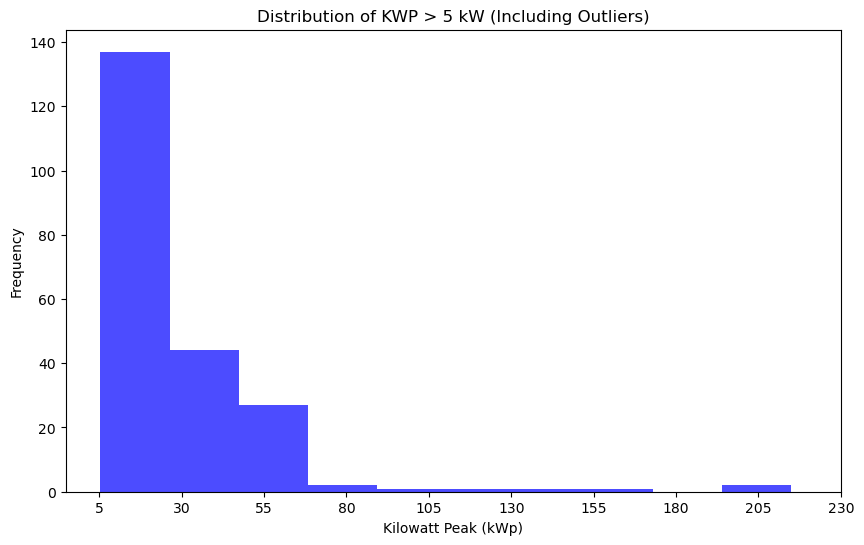

In [17]:
bin_edges, counts = histogram_with_outliers[0], histogram_with_outliers[1]
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], counts, width=bin_widths, color='blue', alpha=0.7, align='edge')
plt.title('Distribution of KWP > 5 kW (Including Outliers)')
plt.xlabel('Kilowatt Peak (kWp)')
plt.ylabel('Frequency')

# Set x-ticks at an interval of 20 starting from 5 up to the last bin edge
tick_interval = 25
plt.xticks(np.arange(start=5, stop=bin_edges[-1] + tick_interval, step=tick_interval))

([<matplotlib.axis.XTick at 0x155524da4490>,
 [Text(5.0, 0, '5'),
  Text(15.0, 0, '15'),
  Text(25.0, 0, '25'),
  Text(35.0, 0, '35'),
  Text(45.0, 0, '45'),
  Text(55.0, 0, '55'),
  Text(65.0, 0, '65')])

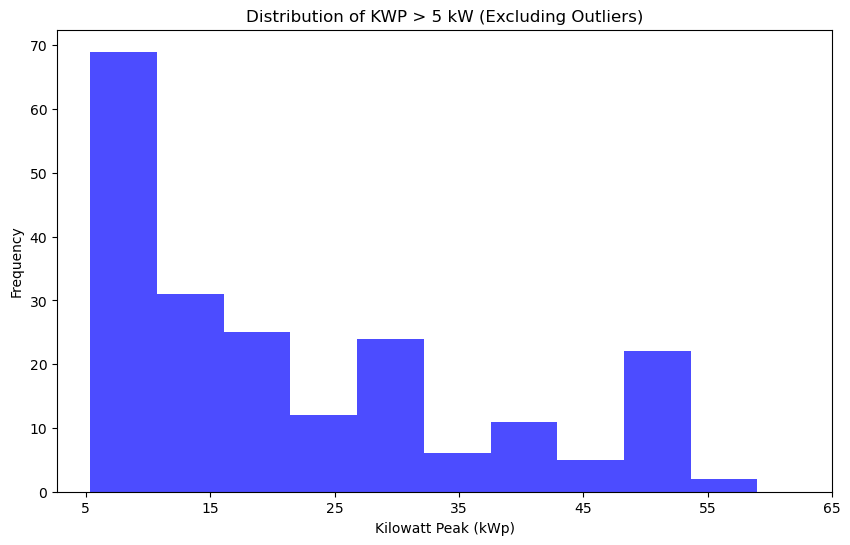

In [18]:
bin_edges, counts = histogram_without_outliers[0], histogram_without_outliers[1]
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], counts, width=bin_widths, color='blue', alpha=0.7, align='edge')
plt.title('Distribution of KWP > 5 kW (Excluding Outliers)')
plt.xlabel('Kilowatt Peak (kWp)')
plt.ylabel('Frequency')

# Set x-ticks at an interval of 20 starting from 5 up to the last bin edge
tick_interval = 10
plt.xticks(np.arange(start=5, stop=bin_edges[-1] + tick_interval, step=tick_interval))

In [19]:
print("Count of entries in filtered_meta_df:", filtered_meta_df.count())
print("Count of entries in filtered_meta_df_no_outliers:", filtered_meta_df_no_outliers.count())

Count of entries in filtered_meta_df: 216
Count of entries in filtered_meta_df_no_outliers: 207


In [20]:
# first calculate quartiles and IQR for the entire dataset
quartiles = meta_df.approxQuantile("kwp", [0.25, 0.75], 0.05)
Q1, Q3 = quartiles[0], quartiles[1]
IQR = Q3 - Q1

# define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# filter out outliers
meta_df_no_outliers = meta_df.filter((meta_df['kwp'] >= lower_bound) & (meta_df['kwp'] <= upper_bound))

# filter for kwp > 5 w/o outliers
filtered_meta_df_no_outliers2 = meta_df_no_outliers.filter(meta_df_no_outliers['kwp'] > 5)

# filter for kwp > 5 incl outliers
filtered_meta_df2 = meta_df.filter(meta_df['kwp'] > 5)

In [21]:
print("Count of entries in filtered_meta_df:", filtered_meta_df2.count())
print("Count of entries in filtered_meta_df_no_outliers:", filtered_meta_df_no_outliers2.count())

Count of entries in filtered_meta_df: 216
Count of entries in filtered_meta_df_no_outliers: 0


In [22]:
systems_over_time_all = meta_df.groupBy("operational_at").count().orderBy("operational_at")
systems_over_time_all.show()

+--------------+-----+
|operational_at|count|
+--------------+-----+
|          NULL|   36|
|    2010-11-18|    1|
|    2010-12-03|   18|
|    2010-12-16|    3|
|    2010-12-20|    5|
|    2010-12-24|    7|
|    2011-01-05|    1|
|    2011-01-07|    1|
|    2011-01-19|    1|
|    2011-01-21|    5|
|    2011-01-27|    1|
|    2011-01-28|    2|
|    2011-02-01|    1|
|    2011-02-03|    7|
|    2011-02-04|    3|
|    2011-02-07|    3|
|    2011-02-08|    2|
|    2011-02-09|    4|
|    2011-02-14|    5|
|    2011-02-21|    4|
+--------------+-----+
only showing top 20 rows



In [25]:
systems_over_time = cleaned_meta_df_no_outliers.groupBy("operational_at").count().orderBy("operational_at")
systems_over_time_pd = systems_over_time.toPandas()
print(systems_over_time_pd.count())

,operational_at,count
0,2010-11-18,1
1,2010-12-03,18
2,2010-12-16,3
3,2010-12-20,5
4,2010-12-24,7
...,...,...
1472,2017-02-02,1
1473,2017-02-23,2
1474,2017-03-06,1
1475,2017-03-07,2


operational_at    1477
count             1477
dtype: int64


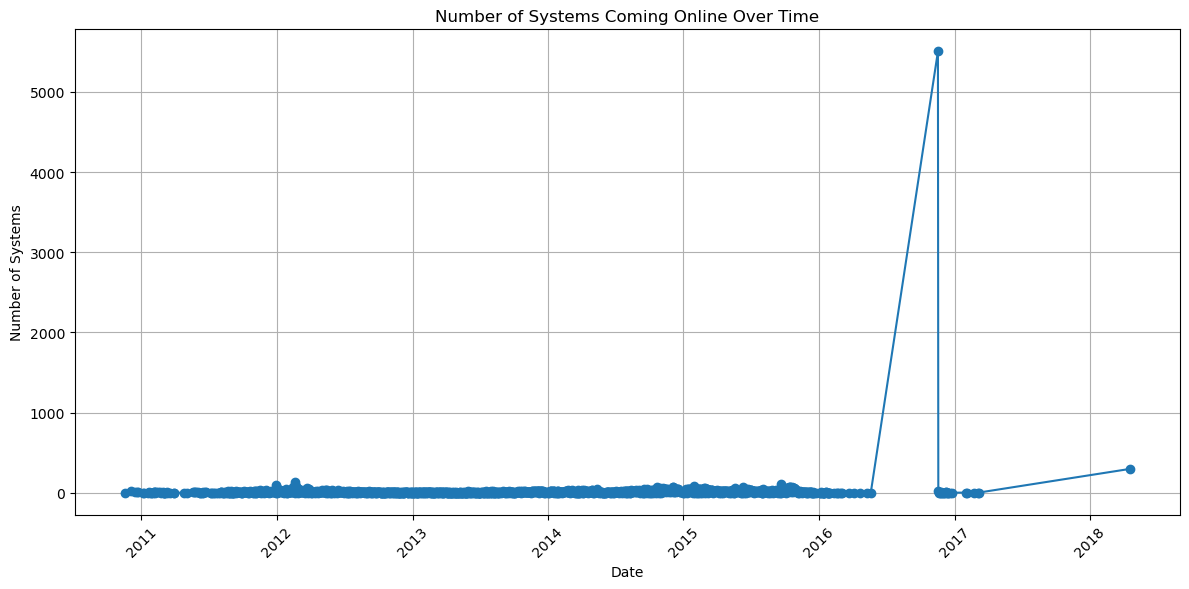

In [26]:
# plot number of systems coming online over time 
plt.figure(figsize=(12, 6))
plt.plot(systems_over_time_pd['operational_at'], systems_over_time_pd['count'], marker='o', linestyle='-')
plt.title('Number of Systems Coming Online Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Systems')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()

73


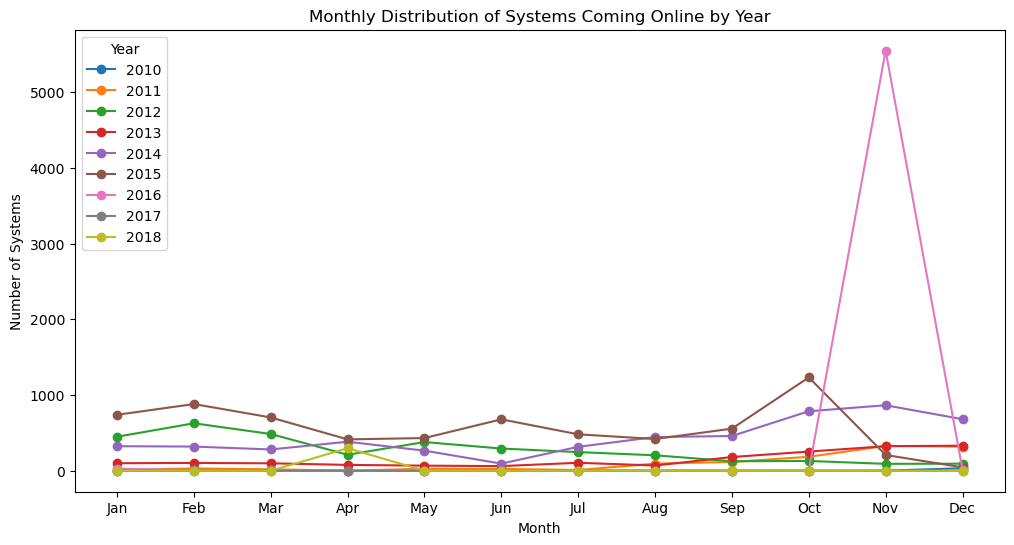

In [27]:
monthly_data = cleaned_meta_df_no_outliers.withColumn("year", F.year("operational_at")) \
                      .withColumn("month", F.month("operational_at")) \
                      .groupBy("year", "month") \
                      .count() \
                      .orderBy("year", "month")

monthly_data_pd = monthly_data.toPandas()
pivoted_data = monthly_data_pd.pivot_table(index='month', columns='year', values='count', fill_value=0)

plt.figure(figsize=(12, 6))
for year in pivoted_data.columns:
    plt.plot(pivoted_data.index, pivoted_data[year], marker='o', label=str(year))

plt.title('Monthly Distribution of Systems Coming Online by Year')
plt.xlabel('Month')
plt.ylabel('Number of Systems')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')

print(monthly_data.count())

In [28]:
peak_row = monthly_data_pd.loc[monthly_data_pd['count'].idxmax()]
print(f"The highest peak occurred in {peak_row['month']}/{peak_row['year']} with {peak_row['count']} systems.")

The highest peak occurred in 11/2016 with 5550 systems.


In [29]:
sorted_data = monthly_data_pd.sort_values(by='count', ascending=False)
sorted_data.reset_index(drop=True, inplace=True)
sorted_data

,year,month,count
0,2016,11,5550
1,2015,10,1233
2,2015,2,881
3,2014,11,865
4,2014,10,786
...,...,...,...
68,2016,4,2
69,2016,5,2
70,2011,4,1
71,2017,1,1


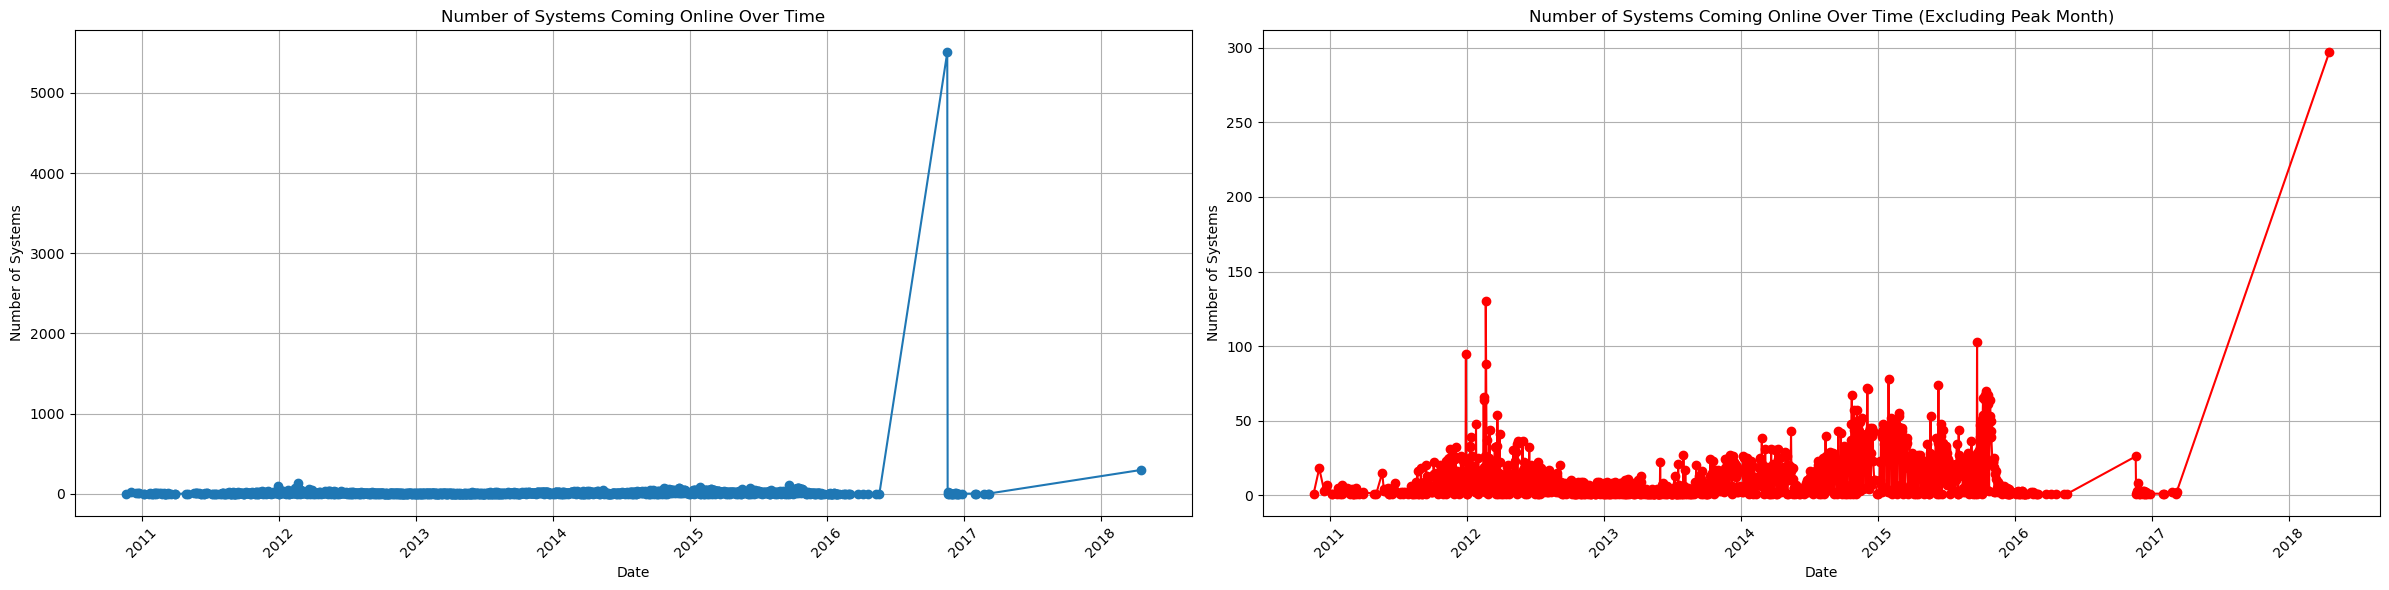

In [30]:
plt.figure(figsize=(24, 6))

# first subplot: all
plt.subplot(1, 2, 1)
plt.plot(systems_over_time_pd['operational_at'], systems_over_time_pd['count'], marker='o', linestyle='-')
plt.title('Number of Systems Coming Online Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Systems')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# peak month
peak_month = systems_over_time_pd.loc[systems_over_time_pd['count'].idxmax()]

# filter out peak month
filtered_data = systems_over_time_pd[systems_over_time_pd['operational_at'] != peak_month['operational_at']]

# second subplot: filtered
plt.subplot(1, 2, 2)
plt.plot(filtered_data['operational_at'], filtered_data['count'], marker='o', linestyle='-', color='red')
plt.title('Number of Systems Coming Online Over Time (Excluding Peak Month)')
plt.xlabel('Date')
plt.ylabel('Number of Systems')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

In [31]:
peak_month

operational_at    2016-11-17
count                   5506
Name: 1453, dtype: object

In [32]:
sorted_data = systems_over_time_pd.sort_values(by='count', ascending=False)
sorted_data

,operational_at,count
1453,2016-11-17,5506
1476,2018-04-18,297
211,2012-02-20,130
1349,2015-09-22,103
164,2011-12-29,95
...,...,...
236,2012-03-17,1
854,2014-03-02,1
836,2014-02-09,1
829,2014-02-01,1


Text(0, 0.5, 'Frequency')

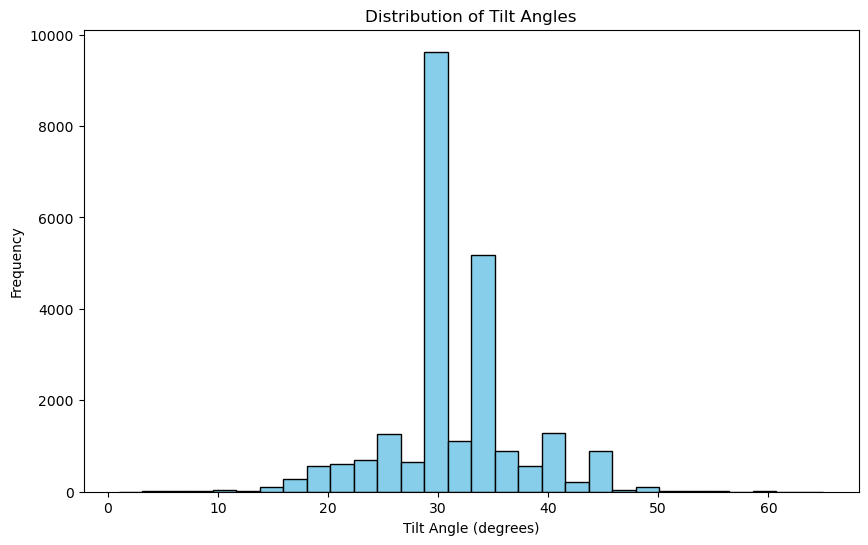

In [34]:
cleaned_meta_df_no_outliers_pd = cleaned_meta_df_no_outliers.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(cleaned_meta_df_no_outliers_pd['tilt'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Tilt Angles')
plt.xlabel('Tilt Angle (degrees)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

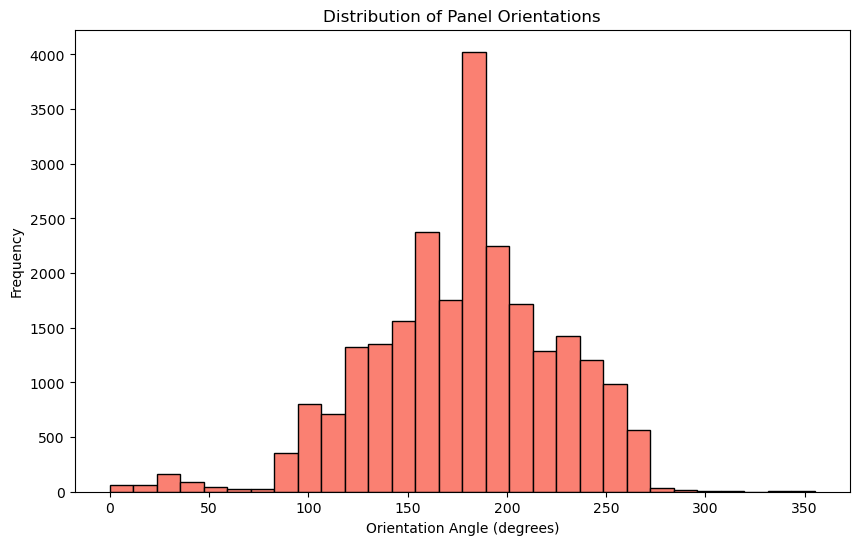

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(cleaned_meta_df_no_outliers_pd['orientation'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Panel Orientations')
plt.xlabel('Orientation Angle (degrees)')
plt.ylabel('Frequency')